### Trabalho de Redes Neurais com TensorFlow [22E3_2]

Professor: DSc. Diego Rodrigues

Aluno: Higor Souza Eller

##### Introdução

Trata-se do treinamento de uma rede neural que vai fornecer uma previsão de tempo resposta para um dado recurso em certas circunstâncias. A rede neural ajudaria na obtenção de uma estimativa de tempo para auxilar no empenho de alguma viatura para efetuar um atendimento de alguma natureza. O ciclo de desenvolvimento da solução seguiu a rotina CRISP.

##### Data understanding

Apesar do foco desta rede ser o tempo resposta de um atendimento, melhor seria se fosse o recurso. Prever qual recurso é o mais recomendado para dada ocorrência é mais útil, entretanto se trataria de um problema multiclasse com um número muito grande de classes.

A base de dados inicial é composta por 822.000 ocorrências atendidas de 2018 até a data atual em 2022. Após os devidos tratamentos o número caiu para algo em torno de 433.000. As entradas são:

Entradas => ['rai',	'data',	'naturezas',	'bairro_cidade',	'recurso',	'tr',	'obm_escala',	'obm_afeto',	'qualificacao',	'sexo']

  - O número rai da ocorrência ("rai"), é uma espécie de ID da ocorrência gerado pelo sistema K9 da SSP.
  - A data ("data") do atendimento, consistindo em um registro de data e hora do acionamento.
  - A natureza do atendimento ("naturezas"). Por exemplo: ataque cardíaco, incêndio em galpão, tentativa de auto-extermínio etc.
  - A cidade e o bairro do atendimento ("bairro_cidade").
  - O tempo resposta ("tr"), o qual consiste no tempo entre o acionamento e o efetivo atendimento.
  - A Unidade Bombeiro Militar que realiza o atendimento ("obm_escala").
  - A Unidade Bombeiro Militar a qual a OBM está afeta, ou seja, a qual OBM ela responde ("obm_afeto")
  - A qualificação da vítima ("qualificacao"). Se é uma vítima comunicante, apenas um comunicante etc.
  - O sexo da vítima ("sexo"). Se é masculino, feminino ou não-informado.


Tipos de dados das entradas = {'rai' : 'int', 'data': 'timestamp', 'naturezas' : 'str', 'bairro_cidade' : 'str', 'recurso' : 'str', 'tr': 'datetime.time', 'obm_escala': 'str', 'obm_afeto': 'str', 'qualificacao': 'str', 'sexo': 'str'}

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from joblib import dump, load
from matplotlib import pyplot
import tensorflow
import pandas
import numpy
import datetime
import seaborn
import itertools

### Data preparation

1. Primeiramente parte dos dados foram carregados em um dataframe. O total não foi carregado devido a necessidade de mais tempo de treinamento e maior capacidade de processamento.

2. As colunas "rai", "obm_afeto", "qualificacao" foram removidas pelo fato de não serem relevantes.

3. Os valores nulos foram removidos.

4. A data que originalmente era do tipo timestamp foi separada em duas colunas categóricas, "dia" e "periodo".

5. O tempo resposta foi categorizado para gerar as classes de saída ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo").

In [21]:
# DATA PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pandas.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1).loc[0:100000,:]

#REMOVING NULL VALUES
for column in df.columns:
    df.loc[pandas.isnull(df[column])]
    df = df.loc[df[column] != "(null)"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]


def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif total_time_in_minutes > 45:
            return response_time_metric[5]
        
#Lembrar de remover os valores que não são datetime.time do df["tr"]
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING "DATA" AND "TR" COLUMNS

df = df.drop(["data", "tr"], axis=1)

#REMOVING NONE VALUES
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df.head()

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


,naturezas,bairro_cidade,recurso,obm_escala,sexo,dia,periodo,tempo_resposta
5,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...,ZONA RURAL - CATALÃO,UR-181,10º BBM - CATALÃO,MASCULINO,Domingo,Madrugada,Muito rápido
6,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ABT-26,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
7,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ASA-74,1º BBM - SETOR CENTRAL,NÃO-INFORMADO,Domingo,Madrugada,Longo
8,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,UR-211,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
9,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,USA-21,BSE,NÃO-INFORMADO,Domingo,Madrugada,Muito longo


### Modeling

1. Os parâmetros de entrada foram escolhidos com base no pattern search realizado no algoritmo anterior. Sendo assim, as funções de ativação das camadas intermediárias que se mostraram mais performáticas foram a "relu" e para a camada de saída a "softmax".

2. A figura de mérito utilizada foi a "precision".

3. Apenas 3 "folds" foram escolhidos por questões de performance.

4. As colunas foram transformadas em vetores por meio do LabelEncoder. Todas as entradas e as saídas necessitaram desta conversão por serem valores textuais.

In [22]:
#COOK PARAMETERS
class_col = 'tempo_resposta'
my_metric = 'accuracy'
random_seed = 33
n_k_folds = 3
my_epochs = 100
hidden_activation = 'relu'
hidden_neurons = 28
learning_rate = 0.001
my_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
my_loss = 'categorical_crossentropy'

In [23]:
print("GPU disponíveis: ", len(tensorflow.config.list_physical_devices('GPU')))

GPU disponíveis:  0


In [24]:
def prepareY(df):
    
    # EXTRACT Y AND DROP FROM DATAFRAME
    Y = df[class_col]

    # ENCODE CLASS VALUES AS INTEGERS
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)

y = prepareY(df)
df = df.drop([class_col], axis=1)
pandas.DataFrame(y).head()

,0
0,3
1,2
2,1
3,2
4,2


In [25]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
     [('cat', OrdinalEncoder(),categorical_ix),
      ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_ix)],
     remainder='drop')

column_trans.fit(df)
X = column_trans.transform(df)
pandas.DataFrame(X).head()

,0,1,2,3,4,5,6
0,175.0,3055.0,256.0,1.0,1.0,0.0,0.0
1,121.0,3127.0,50.0,42.0,2.0,0.0,0.0
2,121.0,3127.0,141.0,20.0,2.0,0.0,0.0
3,121.0,3127.0,285.0,42.0,2.0,0.0,0.0
4,121.0,3127.0,335.0,41.0,2.0,0.0,0.0


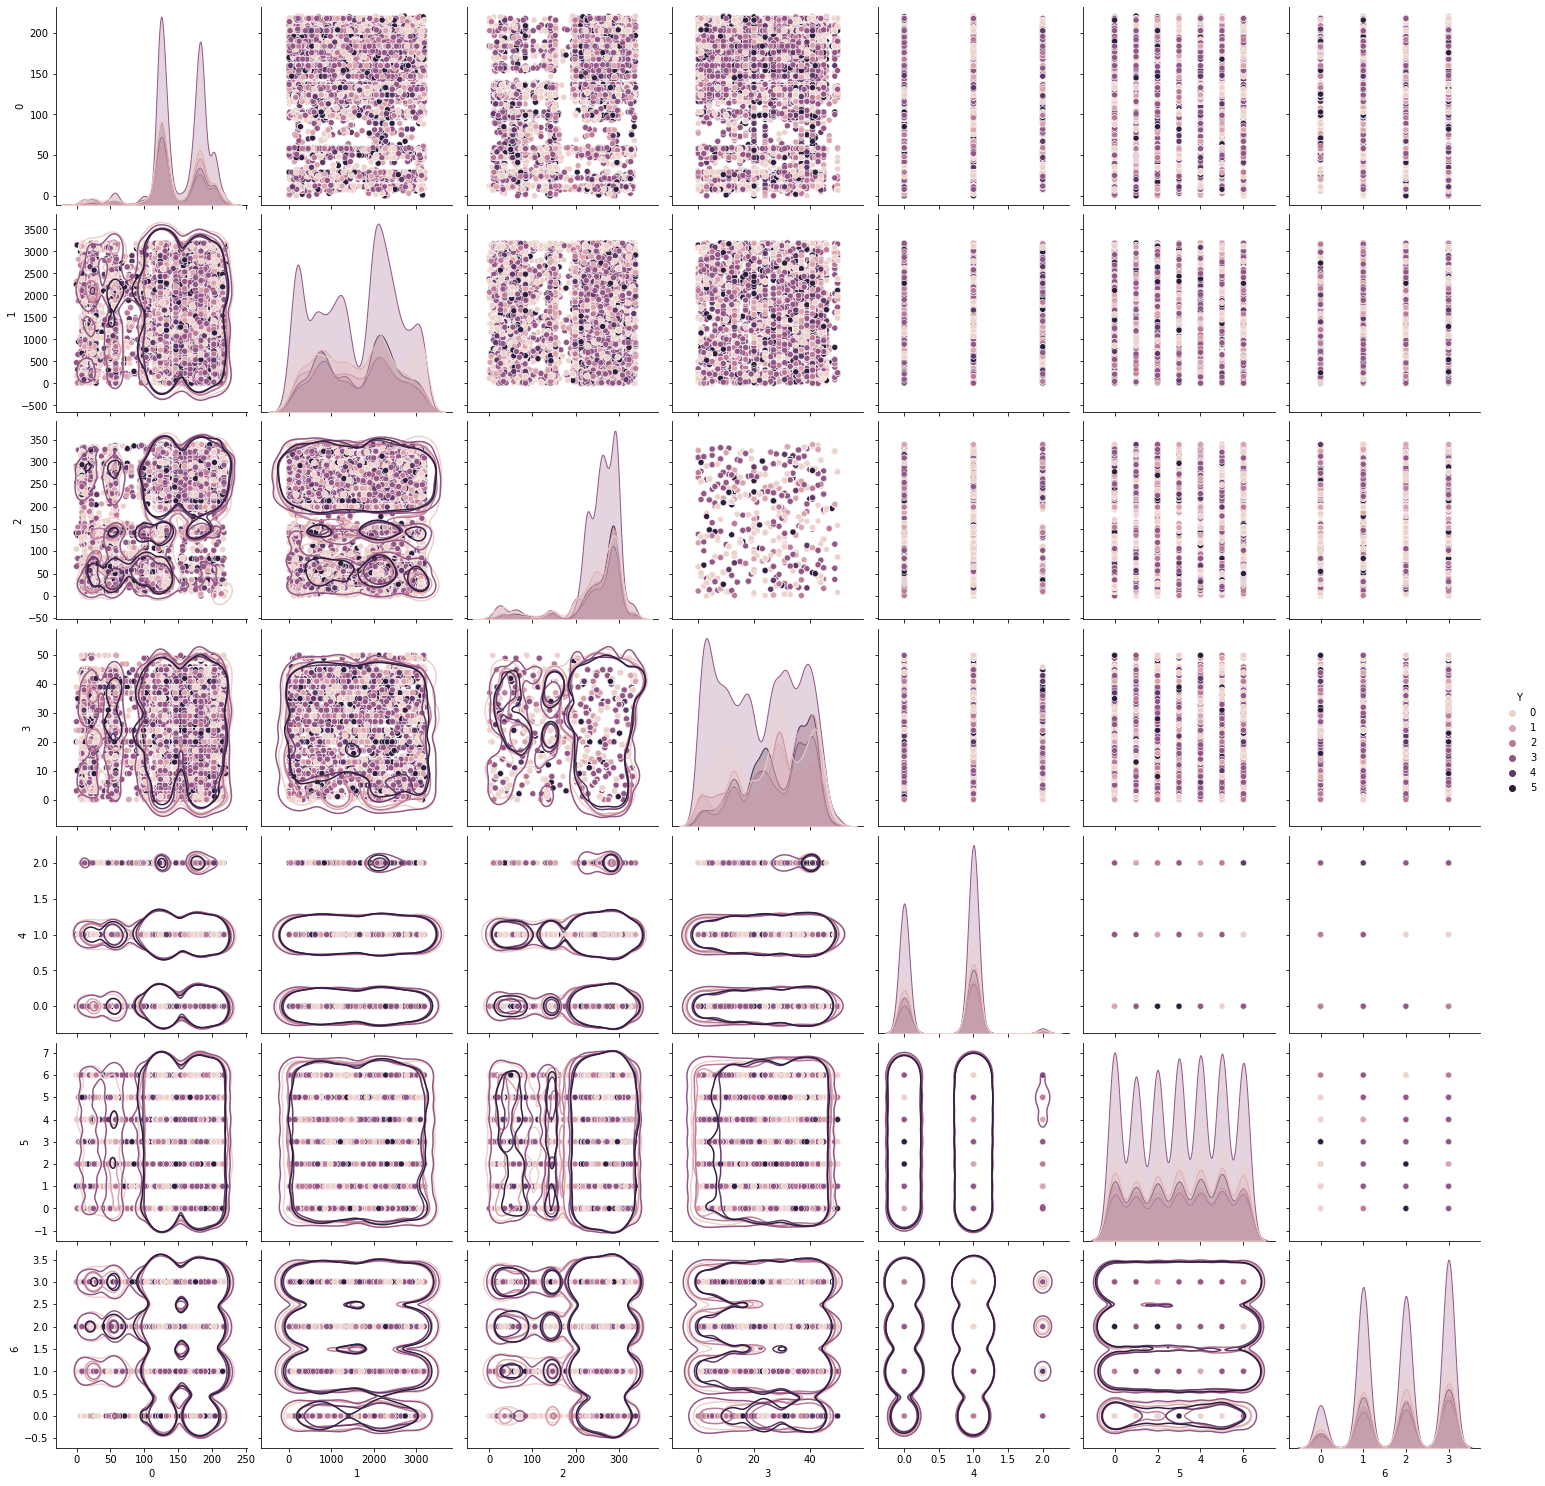

In [27]:
# SCATTER PLOT
df_plot = pandas.DataFrame(X)
df_plot['Y'] = y

g = seaborn.pairplot(df_plot, hue='Y', height=3, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
yhot = np_utils.to_categorical(y)
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

In [29]:
#DEFINE MODEL
def baseline_model():
	# CREATE MODEL
	model = Sequential()
	# DEFINING HIDDEN LAYERS AND NEURONS
	model.add(Dense(28, input_dim=7, activation=hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	
	# DEFINING SOFTMAX FOR MULTI-CLASS CLASSIFICATION
	model.add(Dense(6, activation='softmax'))
	# COMPILE MODEL
	model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)
	return model

# MODEL = BASELINE_MODEL()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=100, verbose=1)

/tmp/ipykernel_4706/1822003026.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=100, verbose=1)


In [30]:
#SETTING THE NUMBER OF FOLDS
kfold = KFold(n_splits=3, shuffle=True)

In [31]:
result = cross_val_score(cmodel, X, yhot, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Epoch 1/100
328/328 [==============================] - 2s 7ms/step - loss: 2.3022 - accuracy: 0.2851
Epoch 2/100
328/328 [==============================] - 1s 4ms/step - loss: 1.7756 - accuracy: 0.3028
Epoch 3/100
328/328 [==============================] - 1s 4ms/step - loss: 1.7515 - accuracy: 0.3063
Epoch 4/100
328/328 [==============================] - 1s 4ms/step - loss: 1.7176 - accuracy: 0.3156
Epoch 5/100
328/328 [==============================] - 1s 4ms/step - loss: 1.7134 - accuracy: 0.3159
Epoch 6/100
328/328 [==============================] - 1s 4ms/step - loss: 1.7015 - accuracy: 0.3218
Epoch 7/100
328/328 [==============================] - 2s 5ms/step - loss: 1.6934 - accuracy: 0.3249
Epoch 8/100
328/328 [==============================] - 1s 5ms/step - loss: 1.6956 - accuracy: 0.3246
Epoch 9/100
328/328 [==============================] - 1s 3ms/step - loss: 1.6893 - accuracy: 0.3281
Epoch 10/100
328/328 [==============================] - 1s 4ms/step - loss: 1.6822 - accura

In [32]:
model = baseline_model()
model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)

history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=my_epochs, batch_size=100, verbose=0)

### Evaluate

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


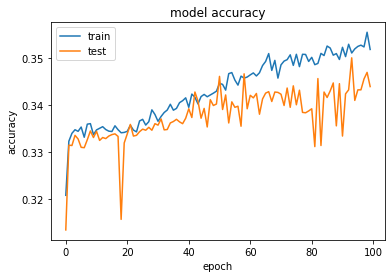

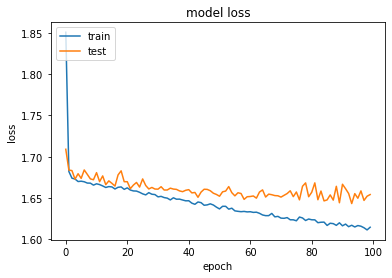

In [33]:
import matplotlib.pyplot as plt
# LIST ALL DATA IN HISTORY
print(history.history.keys())
# SUMMARIZE HISTORY FOR ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# SUMMARIZE HISTORY FOR LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# EVALUATE THE KERAS MODEL
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

308/308 [==============================] - 1s 3ms/step - loss: 1.6478 - accuracy: 0.3460
Accuracy from evaluate: 34.60


In [35]:
# VERIFYING THE PREDICTION ACCURACY
predict_x = model.predict(X_test)
pred = numpy.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 34.595420


In [36]:
print(Y.columns.values)
my_classes = [x[0] for x in Y.columns.values]
df_Y_categorical = ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]

my_conf = confusion_matrix(df_Y_categorical[class_col].to_numpy(), Y_class_est, labels=my_classes)
# df_conf = pandas.DataFrame(my_conf, index=my_classes, columns=['est-{}'.format(x) for x in my_classes])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(12,10)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')

NameError: name 'Y' is not defined